# Import liberaries and functions

In [59]:
import numpy as np
import pandas as pd
import os
import random
import zipfile
import imageio as iio
from PIL import Image
import seaborn as sns
import tensorflow as tf
from PIL import Image, ImageEnhance
from skimage.util import random_noise
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, SpatialDropout2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check that two GPUs are used

**MirroredStrategy instance**

In [60]:
# Create a MirroredStrategy instance
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


**GPU check**

In [61]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

# Set the global policy for mixed precision to use 'mixed_float16'
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Enable XLA (Accelerated Linear Algebra) JIT (Just-In-Time) compilation
# to improve performance by optimizing TensorFlow operations
tf.config.optimizer.set_jit(True)

Num GPUs Available:  2
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Read data using data generator

**Parameters**

In [62]:
training_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
testing_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'
validation_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'
disease_classes = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
size = 150

**Data Generator**

In [63]:
# Training data generator
train_datagen = ImageDataGenerator(rescale=1./255,)

# Testing data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(size,size),
    batch_size=32,
    class_mode='categorical',
    classes=disease_classes,
    shuffle=True
)

# Load the testing data
test_generator = test_val_datagen.flow_from_directory(
    testing_path,
    target_size=(size,size),
    batch_size=32,
    class_mode='categorical',
    classes=disease_classes,
    shuffle=True
)

# Load the validation data
validation_generator = test_val_datagen.flow_from_directory(
    validation_path,
    target_size=(size,size),
    batch_size=32,
    class_mode='categorical',
    classes=disease_classes,
    shuffle=True
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


**View number of images in each disease**

In [64]:
import numpy as np

def count_images(generator, dataset_name, disease_classes):
    class_counts = defaultdict(int)

    # Total number of samples
    num_samples = generator.samples
    num_batches = num_samples // generator.batch_size + 1

    # Count images per class
    for _ in range(num_batches):
        images, labels = next(generator)
        labels = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to class indices
        
        # Count the number of images for each class in the current batch
        for label in labels:
            for disease_name, index in generator.class_indices.items():
                if index == label:
                    class_counts[disease_name] += 1

    # Print counts for each disease
    print(f"{dataset_name} Data:")
    for disease in disease_classes:
        count = class_counts.get(disease, 0)
        print(f"Disease: {disease}, Number of Images: {count}")
    print()

count_images(train_generator, "Training", disease_classes)
count_images(test_generator, "Testing", disease_classes)
count_images(validation_generator, "Validation", disease_classes)

Training Data:
Disease: CaS, Number of Images: 480
Disease: CoS, Number of Images: 450
Disease: Gum, Number of Images: 360
Disease: MC, Number of Images: 540
Disease: OC, Number of Images: 324
Disease: OLP, Number of Images: 540
Disease: OT, Number of Images: 393

Testing Data:
Disease: CaS, Number of Images: 160
Disease: CoS, Number of Images: 149
Disease: Gum, Number of Images: 120
Disease: MC, Number of Images: 180
Disease: OC, Number of Images: 108
Disease: OLP, Number of Images: 180
Disease: OT, Number of Images: 131

Validation Data:
Disease: CaS, Number of Images: 160
Disease: CoS, Number of Images: 149
Disease: Gum, Number of Images: 120
Disease: MC, Number of Images: 180
Disease: OC, Number of Images: 108
Disease: OLP, Number of Images: 180
Disease: OT, Number of Images: 131



**View samples from the data**

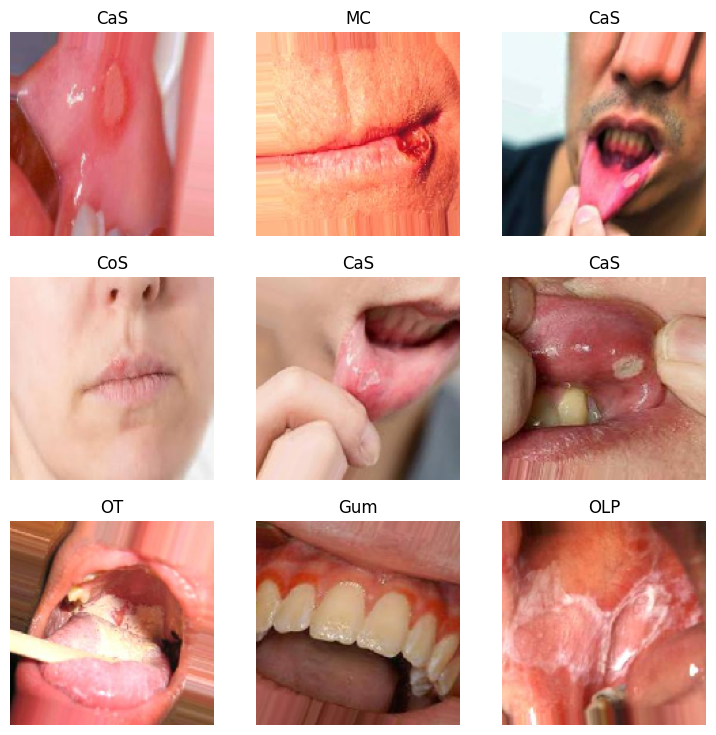

In [65]:
# Define the target number of images to display
target_num_images = 9

# Get a batch of augmented data
train_images, train_labels = next(train_generator)

# Denormalize images for visualization
train_images = train_images * 255.0
train_images = np.clip(train_images, 0, 255).astype(np.uint8)

# Convert one-hot encoded labels to class indices
train_labels = np.argmax(train_labels, axis=1)

# Calculate the number of rows and columns for the plot
num_rows = int(np.sqrt(target_num_images))
num_cols = int(np.ceil(target_num_images / num_rows))

# Display the target number of images from the batch
plt.figure(figsize=(num_cols * 3, num_rows * 3))
for i in range(min(target_num_images, len(train_images))):  # Ensure we do not exceed the batch size
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i])
    plt.title(disease_classes[train_labels[i]])  # Set title as the label of the image
    plt.axis('off')
plt.show()

# Preprocessing

**Augment dataset to be 540 images for each class**

In [66]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import os
# import numpy as np

# # Initialize the ImageDataGenerator with the desired augmentations
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2
# )

# def augment_disease_images_to_target(disease_counts, target_count, input_dir):
#     all_images = []
#     all_labels = []

#     for disease_name, current_count in disease_counts.items():
#         disease_images = []
#         disease_labels = []

#         input_path = os.path.join(input_dir, disease_name)
#         image_files = [f for f in os.listdir(input_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

#         # Ensure the current images count reaches the target count
#         while current_count < target_count:
#             for img_file in image_files:
#                 img_path = os.path.join(input_path, img_file)
#                 img = load_img(img_path)
#                 x = img_to_array(img)
#                 x = np.expand_dims(x, axis=0)
                
#                 for batch in datagen.flow(x, batch_size=1):
#                     augmented_image = batch[0]
#                     disease_images.append(augmented_image)
#                     disease_labels.append(disease_name)
#                     current_count += 1
#                     if current_count >= target_count:
#                         break
#                 if current_count >= target_count:
#                     break

#         # Add the original images to the list before augmenting
#         for img_file in image_files:
#             img_path = os.path.join(input_path, img_file)
#             img = load_img(img_path)
#             x = img_to_array(img)
#             disease_images.append(x)
#             disease_labels.append(disease_name)

#         # Extend the main list with the current disease images and labels
#         all_images.extend(disease_images)
#         all_labels.extend(disease_labels)

#     return np.array(all_images), np.array(all_labels)

# disease_counts = {
#     'CaS': 480,
#     'CoS': 450,
#     'Gum': 360,
#     'MC': 540,
#     'OC': 324,
#     'OLP': 540,
#     'OT': 393
# }

# # Parameters
# target_count = 540
# input_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
# train_images, train_labels = augment_disease_images_to_target(disease_counts, target_count, input_dir)

# Model

**Model architecture**

In [151]:
model = Sequential()

# Convolutional Layer Block 1
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), input_shape=(size, size, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
# model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer Block 2 with larger filters
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
# model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer Block 3 with smaller filters
model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
# model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer Block 4 with smaller filters
model.add(Conv2D(64, (5, 5), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))
# model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(len(disease_classes), activation='softmax'))

**Model optimizer and compiler**

In [152]:
# Create the Adam optimizer with the specified learning rate
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the custom optimizer
model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Display model architecture**

In [153]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 37, 37, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 18, 18, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,028,487 (3.92 MB)

 Trainable params: 1,027,591 (3.92 MB)

 Non-trainable params: 896 (3.50 KB)

**Weights initialization based on class images count**

In [154]:
# Number of samples per class
class_counts = {
    'CaS': 480,
    'CoS': 450,
    'Gum': 360,
    'MC': 540,
    'OC': 324,
    'OLP': 540,
    'OT': 393
}

# Total number of samples
total_samples = sum(class_counts.values())

# Calculate class weights
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts.values())}
print(class_weights)

{0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


**Define LR in callback**

In [155]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if hasattr(self.model.optimizer, 'lr'):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        else:
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(lr)

# Create the callback
lr_logger = LearningRateLogger()

**Fit the model**

In [156]:
epochs = 60
batch_size = 32

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
#   EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    reduce_lr_cb,
    lr_logger
]

# Fit the model with callbacks
history = model.fit(
  train_generator,
  epochs=epochs,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  validation_steps=validation_generator.samples // batch_size,
  verbose=1,
  callbacks=callbacks,
  class_weight=class_weights
)

Epoch 1/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.2388 - loss: 7.0589 - val_accuracy: 0.1445 - val_loss: 5.8420 - learning_rate: 0.0010
Epoch 2/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4062 - loss: 5.1922 - val_accuracy: 0.2500 - val_loss: 5.8615 - learning_rate: 0.0010
Epoch 3/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.3877 - loss: 4.7080 - val_accuracy: 0.1533 - val_loss: 4.2207 - learning_rate: 0.0010
Epoch 4/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 3.5718 - val_accuracy: 0.2500 - val_loss: 4.1675 - learning_rate: 0.0010
Epoch 5/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.4868 - loss: 3.1140 - val_accuracy: 0.1748 - val_loss: 4.1371 - learning_rate: 0.0010
Epoch 6/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - accuracy: 0.5938 - loss: 2.5752 - val_accuracy: 0.0000e+00 - val_loss: 4.5241 - learning_rate: 0.0010
Epoch 7/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5418 - loss: 2.3885 - va

**Check all classes were classified**

In [157]:
predictions = model.predict(test_generator)
print(np.unique(np.argmax(predictions, axis=1)))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
[0 1 2 3 4 5 6]


# Metrics Visualizations


**Check Validation score**

In [158]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9055 - loss: 0.6096
Validation Loss: 0.598506510257721
Validation Accuracy: 0.9134241342544556


**Training and Validation Accuracy**

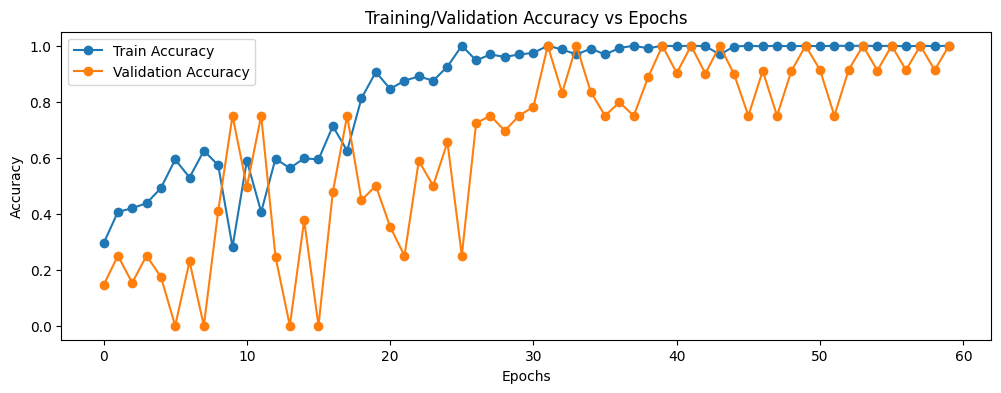

In [159]:
# Extract metrics from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# Plot training and validation accuracy
ax.set_title('Training/Validation Accuracy vs Epochs')
ax.plot(train_accuracy, 'o-', label='Train Accuracy')
ax.plot(val_accuracy, 'o-', label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')

**Training and Validation Loss**

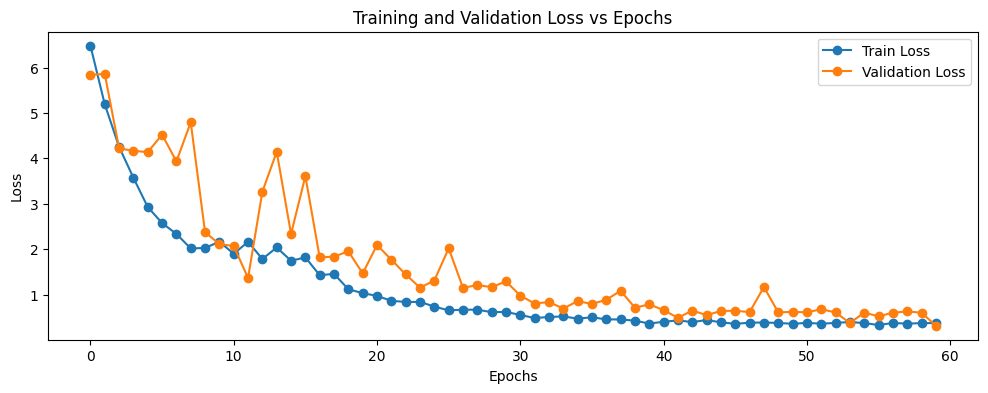

In [160]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# Plot training and validation loss
ax.plot(train_loss, 'o-', label='Train Loss')
ax.plot(val_loss, 'o-', label='Validation Loss')
ax.set_title('Training and Validation Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc='best')

**Learning rate and Epochs**

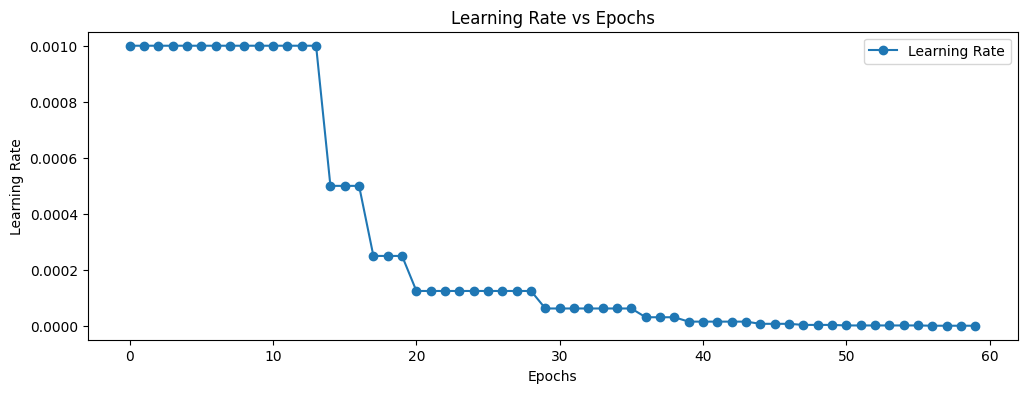

In [161]:
learning_rate = history.history.get('lr', [])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# Plot learning rate
ax.set_title('Learning Rate vs Epochs')
ax.plot(learning_rate, 'o-', label='Learning Rate')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.legend(loc='best')

# Testing

**Display predictions on some sambles**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


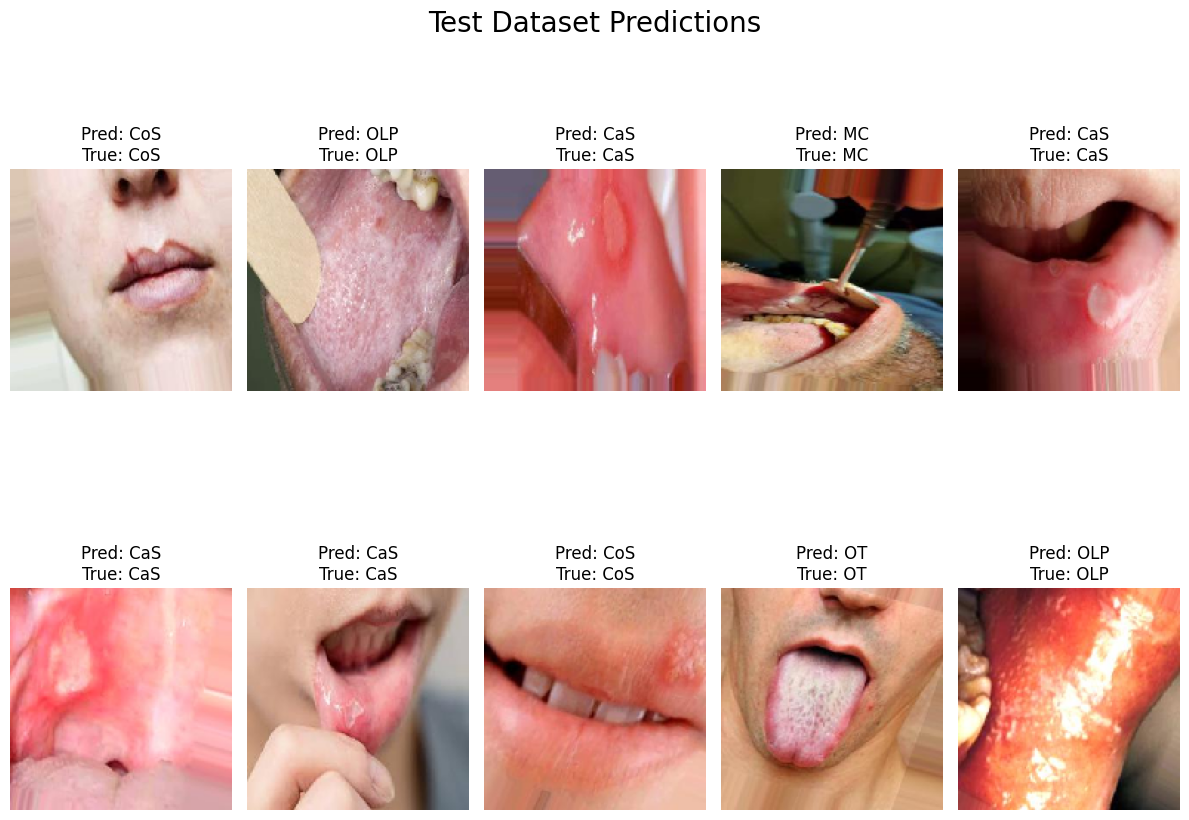

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of data from the test generator
test_images, test_labels = next(test_generator)

# Make predictions
predictions = model.predict(test_images)

# Get class labels and indices
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Convert test_labels to one-hot encoded format for comparison
test_labels_one_hot = np.argmax(test_labels, axis=1)

# Create the plot
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        if idx < len(test_images):  # Ensure index is within bounds
            predicted_label = class_labels[np.argmax(predictions[idx])]
            true_label = class_labels[test_labels_one_hot[idx]]
            ax[i, j].set_title(f"Pred: {predicted_label}\nTrue: {true_label}")
            ax[i, j].imshow(test_images[idx])
            ax[i, j].axis("off")
            idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


**Evaluate the model using Testing dataset**

In [163]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=batch_size)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9076 - loss: 0.6145
Test Loss:     0.616285502910614
Test Accuracy: 0.905642032623291


# Display Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

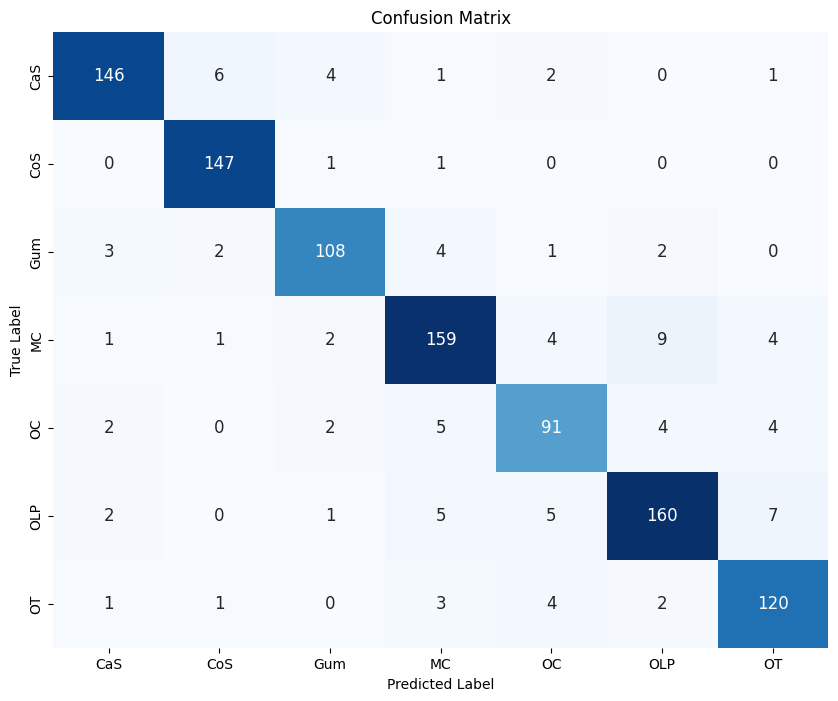

In [164]:
# Function to get predictions and true labels for the entire dataset
def get_predictions_and_labels(generator):
    all_preds = []
    all_labels = []
    
    for batch_images, batch_labels in generator:
        # Predict batch
        batch_preds = model.predict(batch_images)
        
        # If labels are one-hot encoded, use np.argmax to get the class indices
        if batch_labels.ndim > 1:
            batch_labels = np.argmax(batch_labels, axis=1)
        
        # Append predictions and labels
        all_preds.extend(np.argmax(batch_preds, axis=1))
        all_labels.extend(batch_labels)
        
        # Stop if we've processed all data
        if len(all_preds) >= generator.samples:
            break
    
    return np.array(all_labels), np.array(all_preds)

# Reset the generator to start from the beginning
test_generator.reset()

# Get true labels and predictions
y_true, y_pred = get_predictions_and_labels(test_generator)

# Compute the confusion matrix
cf_mtx = confusion_matrix(y_true, y_pred)

# Create a DataFrame for better plotting
class_labels = list(test_generator.class_indices.keys())
cf_df = pd.DataFrame(cf_mtx, index=class_labels, columns=class_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cf_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Classification report

In [165]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

         CaS       0.94      0.91      0.93       160
         CoS       0.94      0.99      0.96       149
         Gum       0.92      0.90      0.91       120
          MC       0.89      0.88      0.89       180
          OC       0.85      0.84      0.85       108
         OLP       0.90      0.89      0.90       180
          OT       0.88      0.92      0.90       131

    accuracy                           0.91      1028
   macro avg       0.90      0.90      0.90      1028
weighted avg       0.91      0.91      0.91      1028

